In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import add_constant
from ISLP import load_data
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
stock_market_data = load_data ('Smarket')
print(stock_market_data.shape)
stock_market_data

(1250, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


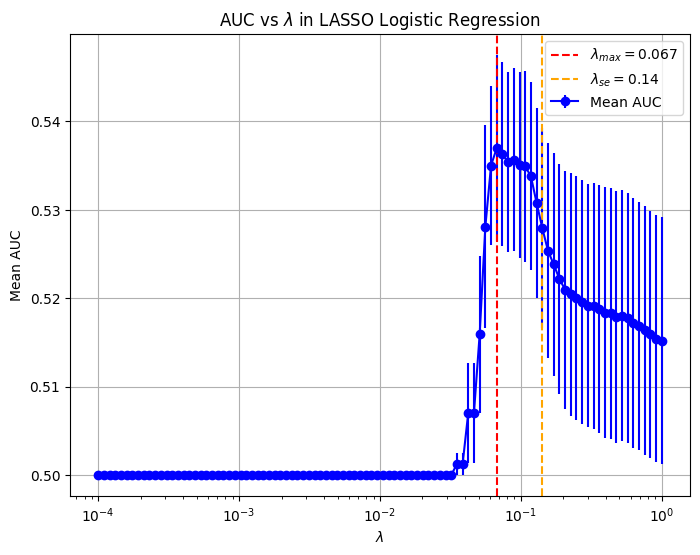

In [3]:
x = stock_market_data.drop(columns = ['Today', 'Direction', 'Year'])
y = stock_market_data.Direction == 'Up'

seed = 1
lambdas = np.logspace(-4, 0, 100)

cv_folds = 5
lasso_cv = LogisticRegressionCV(
    Cs=lambdas,  # Number of inverse regularisation strength values to test (same as `lambda` in the lecture notes)
    cv=cv_folds,  # 5-fold cross-validation
    penalty='l1',  # LASSO (L1 regularisation)
    solver='saga',  # Solver that supports L1 regularisation
    scoring='roc_auc',  # Optimise for AUC
    max_iter=10000,  # Allow for sufficient iterations for convergence
    random_state=seed,
)

# lasso_cv.fit(x, y)
lasso_cv.fit(x, y)

lambdas = lasso_cv.Cs_  
mean_auc_scores = np.mean(lasso_cv.scores_[1], axis=0)
se_auc_scores = np.std(lasso_cv.scores_[1], axis=0)/np.sqrt(cv_folds-1)

plt.figure(figsize=(8, 6))
plt.errorbar(
    lambdas, 
    mean_auc_scores, 
    yerr=se_auc_scores, 
    marker='o', 
    color='blue', 
    label='Mean AUC',
)
plt.xscale('log')  # Use log scale for C values (since C spans several magnitudes)
plt.xlabel(r'$\lambda$')
plt.ylabel('Mean AUC')
plt.title(r'AUC vs $\lambda$ in LASSO Logistic Regression')
plt.grid(True)

max_auc_index = np.argmax(mean_auc_scores)
max_auc = mean_auc_scores[max_auc_index]
max_lambda = lambdas[max_auc_index]
one_se_threshold = max_auc - se_auc_scores[max_auc_index]

one_se_index = np.where(mean_auc_scores >= one_se_threshold)[0][-1]
one_se_lambda = lambdas[one_se_index]

plt.axvline(x=max_lambda, color='r', linestyle='--', label = fr"$\lambda_{{max}}={{{max_lambda:0.2}}}$")
plt.axvline(x=one_se_lambda, color='orange', linestyle='--', label = fr"$\lambda_{{se}}={{{one_se_lambda:.2}}}$")
plt.legend(loc="best")

In [4]:
chosen_lambda = one_se_lambda  # or set to any value you want to test, e.g., 0.1, 1, etc.

lasso_model = LogisticRegression(
    penalty='l1',
    C=chosen_lambda,
    solver='saga',  # SAGA solver supports L1 regularization
    max_iter=10000,
    random_state=seed,
)

lasso_model.fit(x, y)
lasso_model.coef_

array([[-0.05333233, -0.02636666,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [5]:
x_support = x[['Lag1', 'Lag2']]
x_support = add_constant(x_support)

glm_train = sm.GLM(y , x_support, family=sm.families.Binomial())
results = glm_train.fit()

beta_hat = results.params
print(beta_hat)

const    0.074250
Lag1    -0.071510
Lag2    -0.044496
dtype: float64


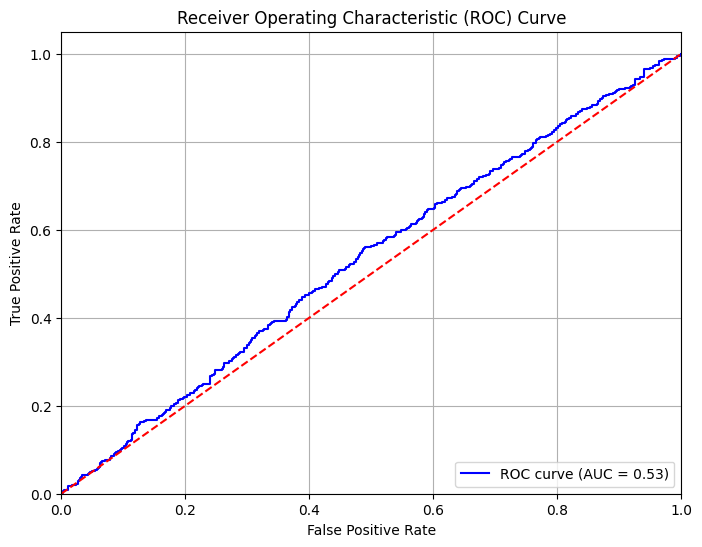

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

probs = results.predict(exog=x_support)
fpr, tpr, thresholds = roc_curve(y, probs)
auc = roc_auc_score(y, probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

### Introduction to Nested Cross-Validation with LASSO

Nested cross-validation is a robust technique used for model selection and evaluation, especially when dealing with methods like **LASSO** (Least Absolute Shrinkage and Selection Operator), which requires hyperparameter tuning. This approach helps prevent overfitting and provides an unbiased estimate of the model's performance by separating the tasks of **hyperparameter optimization** and **model evaluation**.

In nested cross-validation, there are two key loops:
1. **Outer Loop (Model Evaluation)**: The outer loop is responsible for assessing the generalization performance of the model. It splits the dataset into training and testing sets multiple times, ensuring that the model is evaluated on unseen data.
   
2. **Inner Loop (Hyperparameter Tuning)**: The inner loop, nested within the outer loop, is used for selecting the optimal hyperparameters. For LASSO, this means tuning the regularization strength (`alpha`). This loop performs cross-validation on the training data from the outer loop to find the best hyperparameter values.

By using **nested cross-validation**, we ensure that the model selection (through hyperparameter tuning in the inner loop) and performance evaluation (in the outer loop) are independent, reducing the risk of over-optimistic performance estimates. This approach provides a reliable estimate of how the LASSO model will perform on unseen data, making it ideal for evaluating the method’s effectiveness.

In [7]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

inner_cv = KFold(n_splits=10, shuffle=True, random_state=0)

lasso_pipeline = Pipeline([
    ('logreg', LogisticRegressionCV(cv=inner_cv, penalty='l1', solver='saga', max_iter=10000, scoring='roc_auc'))  # Lasso-style regularization
])

nested_scores = cross_val_score(lasso_pipeline, x, y, cv=outer_cv, scoring='roc_auc')

print(f"Nested CV AUC Scores: {nested_scores}")
print(f"Mean AUC: {np.mean(nested_scores):.4f}")

Nested CV AUC Scores: [0.50137635 0.5        0.52121854 0.5        0.5       ]
Mean AUC: 0.5045


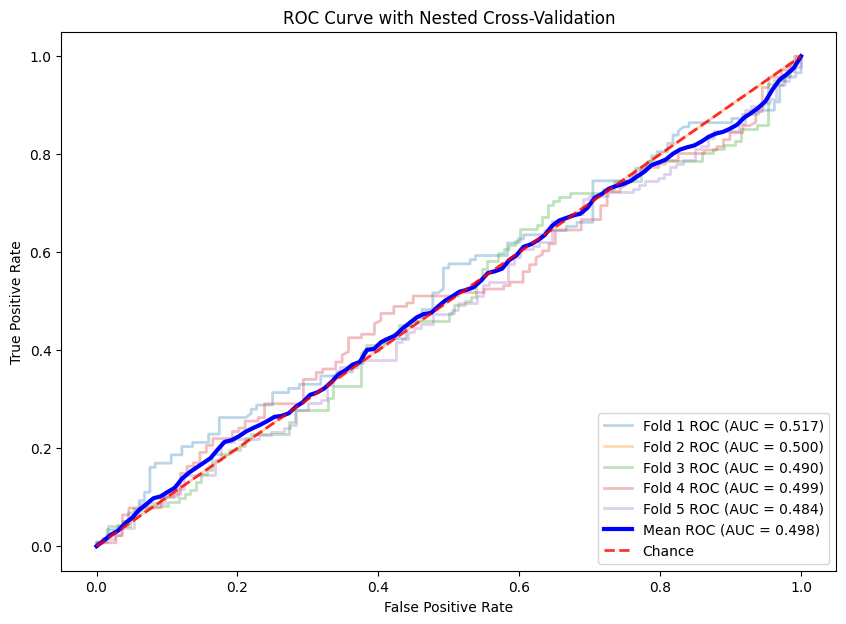

In [8]:
from sklearn.metrics import auc


outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)

lasso_pipeline = Pipeline([
    ('logreg', LogisticRegressionCV(cv=inner_cv, penalty='l1', solver='saga', max_iter=10000, scoring='roc_auc'))
])

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)  # Create mean FPR (False Positive Rate) to interpolate the ROC curve

plt.figure(figsize=(10, 7))

# Nested CV
for i, (train_idx, test_idx) in enumerate(outer_cv.split(x, y)):
    X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    lasso_pipeline.fit(X_train, y_train)
    
    y_proba = lasso_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  # Ensure the TPR starts at 0
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {i+1} ROC (AUC = {roc_auc:.3f})')


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the TPR ends at 1

mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', lw=3, label=f'Mean ROC (AUC = {mean_auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Chance')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Nested Cross-Validation')
plt.legend(loc='lower right')
plt.show()